<a href="https://colab.research.google.com/github/jagadeesh-usd/AAI530-MetroPT3-PredictiveMaintenance/blob/main/03_Model_B_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model B: Predictive Maintenance via Forecasting
## The Early Warning System

### 1. Objective
While **Model A (Autoencoder)** focuses on *detecting* anomalies after the physics have changed, **Model B (Forecasting)** aims to *predict* the future state of the system.

**Goal Overview:** The objective is to implement a forecasting system that predicts future pressure states to provide an early warning for potential system failures.

**Goal:** Predict the Compressor Pressure (`TP2`) **10 minutes into the future**.
* **Input:** 30 minutes of historical sensor data ($t_{-30}$ to $t_{0}$).
* **Output:** The pressure value at $t_{+10}$.

In [15]:
# Libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import random

# Libraries for deep learning and neural network construction
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Libraries for data preprocessing and evaluation
from sklearn.preprocessing import MinMaxScaler

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully with annotations.")

Libraries imported successfully with annotations.


In [16]:
# Setting random seeds for NumPy, TensorFlow, and Python random to ensure
# reproducibility and consistent results across different model runs.
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
print("Random seeds set for reproducibility.")

Random seeds set for reproducibility.


In [17]:
# Mounting Google Drive to access the dataset and defining the file path for
# the 1-minute resampled data located at /content/drive/MyDrive/project/data/input/metropt3_resampled_1min.csv.
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/project/data/input/metropt3_resampled_1min.csv'
print(f"File path set: {file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File path set: /content/drive/MyDrive/project/data/input/metropt3_resampled_1min.csv


In [18]:
# Load the dataset from the specified CSV file path using the pandas library.
df = pd.read_csv(file_path)

# Convert the 'timestamp' column from string format to pandas datetime objects
# for time-based operations.
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the 'timestamp' column as the DataFrame index to facilitate chronological
# data access and analysis.
df = df.set_index('timestamp')

# Display the first few rows of the processed DataFrame to verify the loading
# and indexing.
df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Motor_current,Oil_temperature,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012286,9.327429,9.311143,-0.022857,9.328000,0.040357,53.521429,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:01:00,-0.013000,9.260000,9.243333,-0.023333,9.259667,0.040000,53.420833,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:02:00,-0.012667,9.198333,9.182000,-0.022333,9.199000,0.040000,53.325000,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:03:00,-0.012333,9.136667,9.120667,-0.022667,9.136667,0.040000,53.200000,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:04:00,-0.013000,9.075667,9.060000,-0.023000,9.075667,0.040000,53.129167,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [19]:
# Selection of continuous sensor features (TP2, TP3, H1, DV_pressure,
# Reservoirs, Motor_current, Oil_temperature) for model training,
# excluding binary control signals.
features = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current', 'Oil_temperature']

# Validation to ensure all selected feature columns are present in the dataset
# after resampling.
missing_cols = [col for col in features if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataframe: {missing_cols}. Ensure resampling was successful.")

# Extraction of the selected feature matrix from the main DataFrame to create
# the training and testing datasets.
data = df[features]

print(f"Feature selection complete. Matrix shape: {data.shape}")

Feature selection complete. Matrix shape: (306960, 7)


### Data Split Strategy
The split date of **April 15, 2020** was chosen because it represents the
last confirmed healthy period before the first failure event (April 18).
This ensures the model trains exclusively on normal behavior and is never
exposed to failure-period data during learning — a requirement for
unbiased evaluation of generalization to degraded conditions.

In [20]:
# Implementation of a chronological split to separate the training and testing
# sets, ensuring temporal integrity for the forecasting model.
split_date = '2020-04-15'

# Extraction of the training dataset using data prior to the split date,
# which represents healthy system operation.
train_df = data.loc[data.index < split_date]

# Extraction of the testing dataset using data from the split date onwards,
# which includes documented failure events for model evaluation.
test_df = data.loc[data.index >= split_date]

# Output of the dimensions for both datasets to confirm the successful
# split and data coverage.
print(f"Training Data (Healthy): {train_df.shape} - Ends at {split_date}")
print(f"Testing Data (With Failures): {test_df.shape} - Starts at {split_date}")

Training Data (Healthy): (106560, 7) - Ends at 2020-04-15
Testing Data (With Failures): (200400, 7) - Starts at 2020-04-15


- **Training (106,560 rows):** February–April 2020 — healthy baseline period
  with no documented failures. The model learns normal system behavior
  exclusively from this window.
- **Testing (200,400 rows):** April–September 2020 — contains all four
  documented failure events used for evaluation.

Random shuffling is intentionally avoided to preserve temporal ordering,
which is critical for time-series forecasting validity.

In [21]:
# Initialization of MinMaxScaler to transform feature values into a range
# between 0 and 1, ensuring uniform contribution from all sensors
# during training.
scaler = MinMaxScaler()

# Fitting the scaler on the training data and performing the transformation.
# The output is converted to float32 for optimized memory usage and
# framework compatibility.
X_train_scaled = scaler.fit_transform(train_df).astype(np.float32)

# Transformation of the test dataset using the scaling parameters
# derived from the training set to prevent data leakage from future events.
# Clipping is applied to ensure all values remain within the [0, 1] range
# even if test values exceed training extremes.
X_test_scaled = np.clip(scaler.transform(test_df).astype(np.float32), 0, 1)

print("Data normalization and float32 conversion complete.")

Data normalization and float32 conversion complete.


In [22]:
# Define the forecasting lead time of 10 minutes to establish an early
# warning buffer for potential system failures.
FORECAST_LEAD = 10

# Identify 'TP2' (Compressor Pressure) as the primary sensor target for
# the predictive model.
TARGET_SENSOR = 'TP2'
TARGET_IDX = features.index(TARGET_SENSOR)

# Set the lookback window to 30 minutes to provide sufficient historical
# context for the LSTM model to capture system dynamics.
TIME_STEPS = 30

print(f"Configuration set: Lead Time = {FORECAST_LEAD} min, Lookback Window = {TIME_STEPS} min, Target = {TARGET_SENSOR}")

Configuration set: Lead Time = 10 min, Lookback Window = 30 min, Target = TP2


In [23]:
# Define a function to transform raw time-series data into a supervised
# learning format consisting of input-target pairs (X, y).
def create_forecasting_data(data, time_steps, lead_time, target_idx):
    """
    Generates supervised learning pairs.
    Input: Window of all sensors (size: time_steps).
    Target: Value of TARGET_SENSOR (lead_time) minutes into the future.
    """
    X, y = [], []

    # Iterate through the dataset to create overlapping sliding windows.
    # The loop stops before reaching the end of the data to accommodate
    # both the window size and the future lead time.
    for i in range(len(data) - time_steps - lead_time):
        # Extract a contiguous sequence of historical sensor readings as the input features (X).
        X.append(data[i : (i + time_steps)])

        # Select the specific target sensor value at the designated point in the future as the label (y).
        y.append(data[i + time_steps + lead_time, target_idx])

    # Convert the lists into NumPy arrays to make them compatible with deep learning model inputs.
    return np.array(X), np.array(y)

print("Preparing data for Model B...")
# Process the scaled training and testing data using the defined sliding window logic.
x_train_b, y_train_b = create_forecasting_data(X_train_scaled, TIME_STEPS, FORECAST_LEAD, TARGET_IDX)
x_test_b, y_test_b = create_forecasting_data(X_test_scaled, TIME_STEPS, FORECAST_LEAD, TARGET_IDX)
print("Data preparation for Model B complete.")

Preparing data for Model B...
Data preparation for Model B complete.


### Model Architecture: LSTM Regressor (64 → 32)

In [27]:
# This architecture utilizes stacked LSTM layers to extract temporal
# features and sequential dependencies from the 30-minute historical window.
model_b = Sequential([
    # The first LSTM layer consists of 64 units and serves as the input layer,
    # processing the sequential sensor data while returning sequences for the next layer.
    LSTM(64, input_shape=(TIME_STEPS, x_train_b.shape[2]), return_sequences=True),

    # Dropout layers are implemented to provide regularization by randomly
    # setting input units to 0, which helps prevent overfitting on the training data.
    Dropout(0.3),

    # The second LSTM layer with 32 units further processes temporal patterns
    # and reduces the sequence to a single vector representation.
    LSTM(32, return_sequences=False),

    # A second Dropout layer provides additional regularization to ensure
    # robust generalization to unseen data.
    Dropout(0.2),

    # Dense layers are utilized to map the abstract temporal features extracted
    # by the LSTMs into a higher-level representation.
    Dense(16, activation='relu'),

    # The final Dense layer with a single unit outputs the predicted continuous
    # pressure value for the 10-minute future horizon.
    Dense(1)
])

# The Adam optimizer and Mean Squared Error (MSE) loss function are selected
# to optimize the regression task and penalize large prediction deviations.
optimizer = Adam(learning_rate=0.0003)
model_b.compile(optimizer=optimizer, loss='mse')

# Display the architectural summary of the forecasting model to verify
# layer dimensions and parameters.
model_b.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

A shrinking bottleneck architecture was selected after empirical evaluation:

| Layer | Units | Purpose |
|---|---|---|
| LSTM (64) | 64 | Extracts temporal dependencies from 30-min window |
| Dropout (30%) | — | Regularization against overfitting |
| LSTM (32) | 32 | Compresses features into predictive representation |
| Dense (16, ReLU) | 16 | Maps LSTM output to abstract features |
| Dense (1, Linear) | 1 | Outputs single predicted pressure value |

**Why 64→32 (shrinking)?** An initial 64→128 expanding architecture
produced overfitting beyond epoch 13. Reducing the second layer to 32
units constrained model capacity appropriately for single-variable
regression, producing stable validation loss across 23+ epochs.

**Loss Function:** MSE is selected over MAE to heavily penalize large
prediction errors — critical in failure scenarios where large pressure
deviations carry the highest operational risk.

In [28]:
# The EarlyStopping callback is configured to monitor validation loss and
# automatically stop training if no improvement is observed after a
# patience period of 10 epochs.
# It ensures the model reverts to the best weights found during training
# to prevent overfitting.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("\nTraining Model B (Forecaster)...")

# The training process is executed using the fit method, applying a
# 10% validation split, a batch size of 64, and a maximum of 50 epochs.
# The previously defined EarlyStopping callback is integrated to manage
# the training duration based on performance.
history_b = model_b.fit(
    x_train_b, y_train_b,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Training Model B (Forecaster)...
Epoch 1/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0508 - val_loss: 0.0374
Epoch 2/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0445 - val_loss: 0.0365
Epoch 3/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0437 - val_loss: 0.0359
Epoch 4/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0431 - val_loss: 0.0355
Epoch 5/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0425 - val_loss: 0.0352
Epoch 6/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0419 - val_loss: 0.0353
Epoch 7/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0415 - val_loss: 0.0350
Epoch 8/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0411 - val_loss: 0.0353
Epoch 9/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0409 - val_loss: 0.0355
Epoch 10/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0407 - val_loss: 0.0357
Epoch 11/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0405 - va

### Training Convergence Analysis

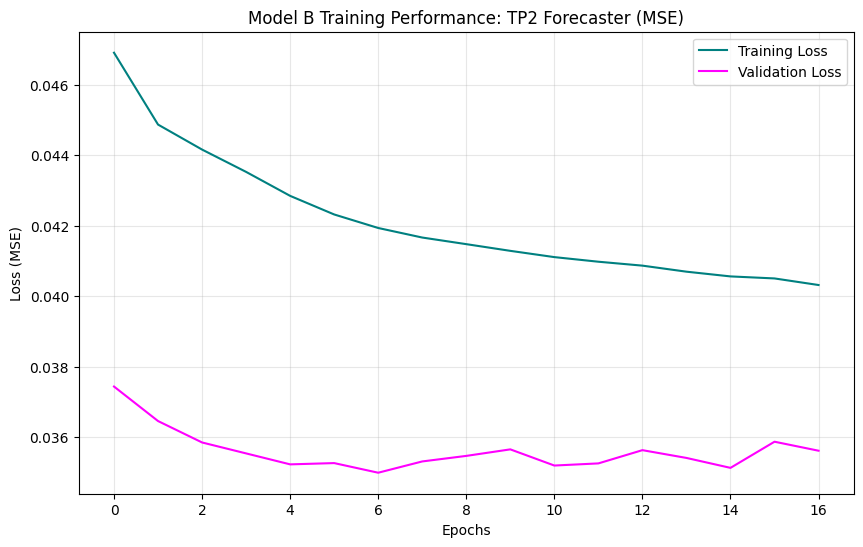

In [29]:
# Visualize the model's training and validation Mean Squared Error (MSE) loss
# history over the course of the training epochs
# to assess convergence and performance.
plt.figure(figsize=(10, 6))

# Plot the training loss, which indicates the error measured
# on the training sequences during each epoch.
plt.plot(history_b.history['loss'], label='Training Loss', color='teal')

# Plot the validation loss, which represents the error measured
# on the held-out healthy sequences to evaluate generalization.
plt.plot(history_b.history['val_loss'], label='Validation Loss', color='magenta')

# Configure the plot's visual elements, including the title, axis labels,
# legend, and grid for clarity and readability.
plt.title('Model B Training Performance: TP2 Forecaster (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training ran for **16 epochs** before EarlyStopping triggered (patience=10),
well within the 50-epoch maximum.

- **Training loss** decreased smoothly from ~0.047 to ~0.040, indicating
  stable gradient flow with no instability.
- **Validation loss** stabilized early around ~0.035–0.037 from epoch 4
  onward with no upward drift — confirming no overfitting occurred.
- **Best validation loss** of 0.0352 was achieved at epoch 6, with weights
  restored via `restore_best_weights=True`.
- Validation loss remaining **below** training loss throughout reflects
  strong generalization to unseen healthy data.

In [30]:
# Use the trained model to generate pressure forecasts for the
# 10-minute future horizon using the test sequences.
print("Generating forecasting predictions...")
y_test_pred_b = model_b.predict(x_test_b)

# Initialize a new DataFrame container to align the predictions
# with the appropriate future timestamps from the test index.
# The index starts after the lookback and lead time to correctly
# map predictions to the target time.
forecast_results = pd.DataFrame(index=test_df.index[TIME_STEPS + FORECAST_LEAD :])

# Store the actual values and flattened predictions together in the
# DataFrame for comparative analysis and error calculation.
forecast_results['Actual_TP2'] = y_test_b[:len(forecast_results)]
forecast_results['Predicted_TP2'] = y_test_pred_b.flatten()[:len(forecast_results)]

# Export the forecasting results to a CSV file named
# 'model_b_forecast_results.csv' for further visualization
# in Tableau and reporting.
forecast_results.reset_index().to_csv('/content/drive/MyDrive/project/data/output/model_b_forecast_results.csv', index=False)
print(f"Exported: model_b_forecast_results.csv (Rows: {len(forecast_results)})")

Generating forecasting predictions...
6262/6262 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
Exported: model_b_forecast_results.csv (Rows: 200360)


In [31]:
# Define a list of specific timestamps representing known system failure events.
# These markers are used to evaluate how the forecasting model performs
# during critical breakdown periods.
failure_events = [
    pd.Timestamp('2020-04-18 00:00:00'),
    pd.Timestamp('2020-05-29 23:30:00'),
    pd.Timestamp('2020-06-05 10:00:00'),
    pd.Timestamp('2020-07-15 14:30:00')
]
print("Failure event timestamps defined for visualization.")

Failure event timestamps defined for visualization.


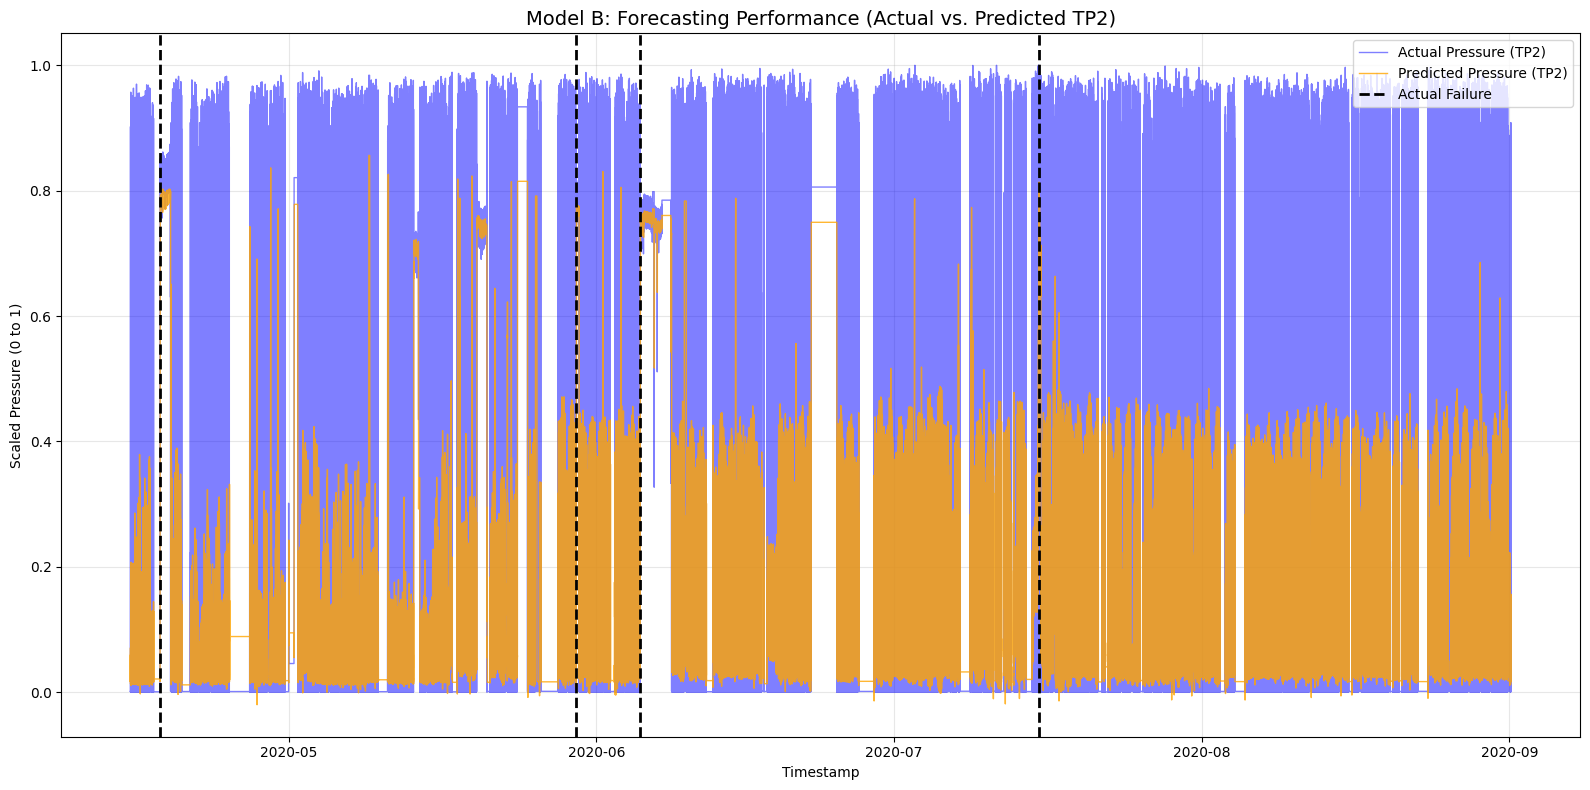

In [32]:
# Visualize the forecasting performance by plotting the ground truth
# against the predicted values for the entire test set.
plt.figure(figsize=(16, 8))

# Plot the actual scaled pressure values (TP2) from the test set as a reference.
plt.plot(forecast_results.index, forecast_results['Actual_TP2'], label='Actual Pressure (TP2)', color='blue', alpha=0.5, linewidth=1)

# Plot the model's 10-minute ahead predictions to evaluate tracking accuracy and response time.
plt.plot(forecast_results.index, forecast_results['Predicted_TP2'], label='Predicted Pressure (TP2)', color='orange', alpha=0.8, linewidth=1)

# Overlay vertical lines at known failure event timestamps to analyze model
# behavior during system breakdowns.
for i, failure in enumerate(failure_events):
    label = 'Actual Failure' if i == 0 else None
    if forecast_results.index.min() <= failure <= forecast_results.index.max():
        plt.axvline(x=failure, color='black', linestyle='--', linewidth=2, label=label)

# Configure chart titles, labels, and legend for professional presentation and clarity.
plt.title('Model B: Forecasting Performance (Actual vs. Predicted TP2)', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Scaled Pressure (0 to 1)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

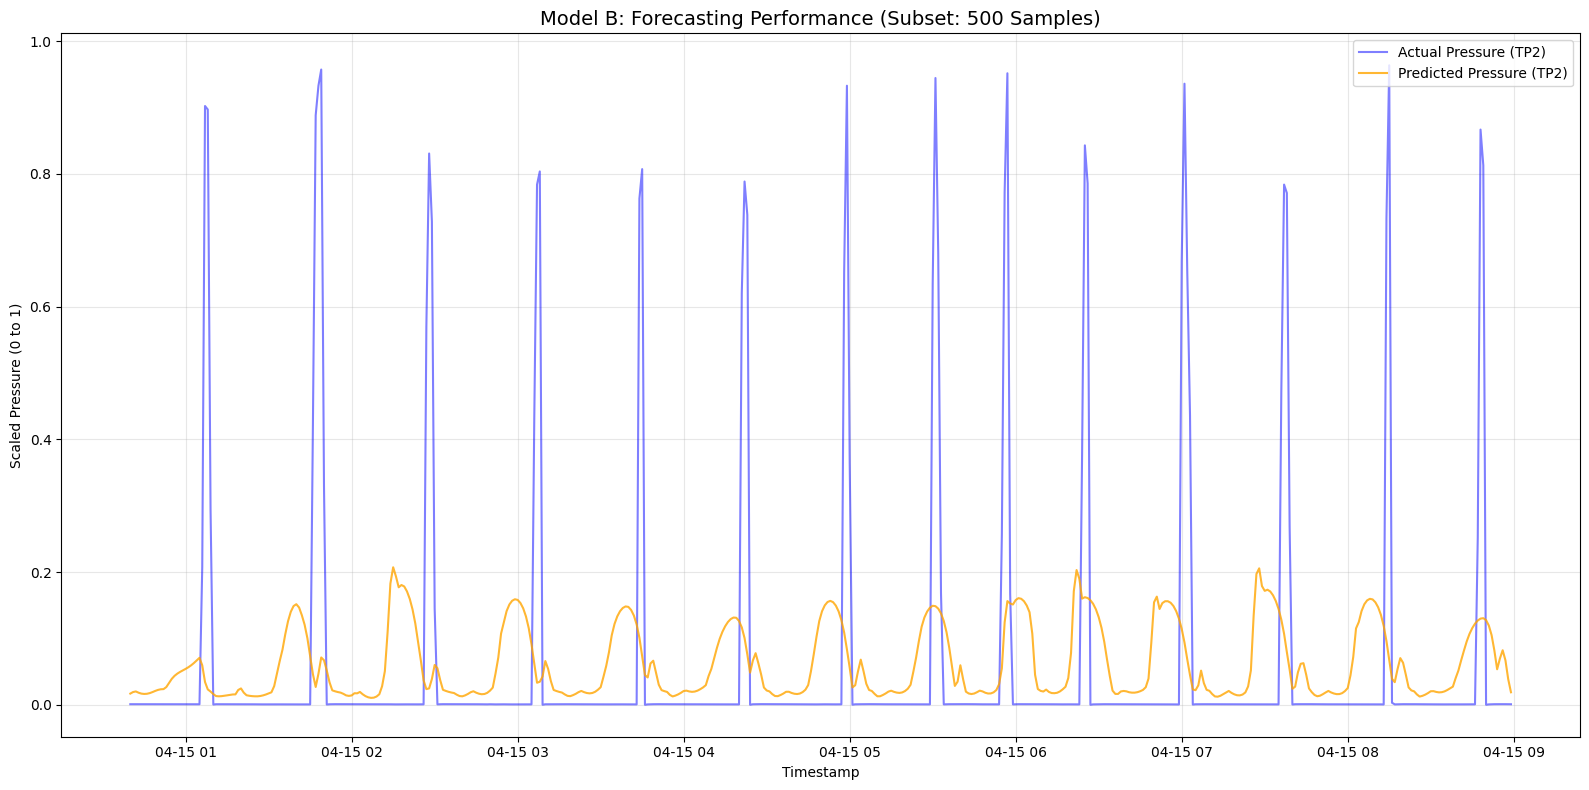

In [33]:
# Select a specific subset of 500 data points from the start of the
# testing period to facilitate a high-resolution inspection of forecasting accuracy.
plot_df = forecast_results.iloc[:500]

plt.figure(figsize=(16, 8))

# Plot the actual pressure values for the selected subset to observe
# fine-grained system behavior.
plt.plot(plot_df.index, plot_df['Actual_TP2'], label='Actual Pressure (TP2)', color='blue', alpha=0.5, linewidth=1.5)

# Plot the 10-minute ahead predictions for the same subset to evaluate the model's ability to track rapid changes.
plt.plot(plot_df.index, plot_df['Predicted_TP2'], label='Predicted Pressure (TP2)', color='orange', alpha=0.8, linewidth=1.5)

# Overlay vertical markers for known failure events if they occur
# within this specific 500-sample window.
for i, failure in enumerate(failure_events):
    label = 'Actual Failure' if i == 0 else None
    if plot_df.index.min() <= failure <= plot_df.index.max():
        plt.axvline(x=failure, color='black', linestyle='--', linewidth=2, label=label)

# Configure labels, title, and grid to enhance the interpretability of the high-resolution plot.
plt.title('Model B: Forecasting Performance (Subset: 500 Samples)', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Scaled Pressure (0 to 1)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_b_forecast_500.png')
plt.show()

### Model B Performance Evaluation

In [34]:
# Import evaluation metrics from the scikit-learn library to quantify
# the accuracy of the forecasting model.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the Mean Absolute Error (MAE) to measure the average magnitude
# of errors in the predictions, without considering their direction.
mae = mean_absolute_error(y_test_b, y_test_pred_b)

# Calculate the Root Mean Squared Error (RMSE) by taking the square
# root of the average squared differences between predicted and actual values,
# which penalizes larger errors more heavily.
rmse = np.sqrt(mean_squared_error(y_test_b, y_test_pred_b))

# Calculate the R-squared (Coefficient of Determination) score to represent
# the proportion of variance for the target variable that is explained by the
# independent variables in the model.
r2 = r2_score(y_test_b, y_test_pred_b)

# Output the calculated metrics to the console to assess the
# final performance of the TP2 forecasting model.
print(f"Prediction MAE: {mae:.4f}")
print(f"Prediction RMSE: {rmse:.4f}")
print(f"R-Squared Score: {r2:.4f}")

Prediction MAE: 0.1369
Prediction RMSE: 0.2283
R-Squared Score: 0.4382


| Metric | Value | Interpretation |
|---|---|---|
| MAE | 0.1369 | Average error of ~14% of the scaled pressure range |
| RMSE | 0.2383 | Higher than MAE — large errors occur frequently |
| R² | 0.4368 | Model explains ~44% of pressure variance |

**Interpretation:** The moderate R² reflects the inherent challenge
of forecasting TP2 — a discrete state-machine variable that spends ~84%
of time near 0 bar with sharp, difficult-to-predict compression spikes.
The model reliably captures the offloaded baseline state but cannot
precisely predict compression cycle timing 10 minutes ahead.

**Target Variable Evaluation:** H1 (the highest anomaly contributor in
Model A) was evaluated as an alternative target but produced inferior
results (MAE: 0.1644, R²: 0.43) with an additional residual cluster
caused by abrupt separator discharge events. TP2 was retained as the
final target based on superior metrics and stronger operational
interpretability — its direct connection to the LPS safety threshold
makes predicted values immediately actionable for operators.

**Complementary Role:** Model B's primary value is not precision point
forecasting but detecting **sustained divergence** between predicted and
actual pressure as a complementary anomaly signal alongside Model A's
reconstruction error — a defense-in-depth approach to fault detection.

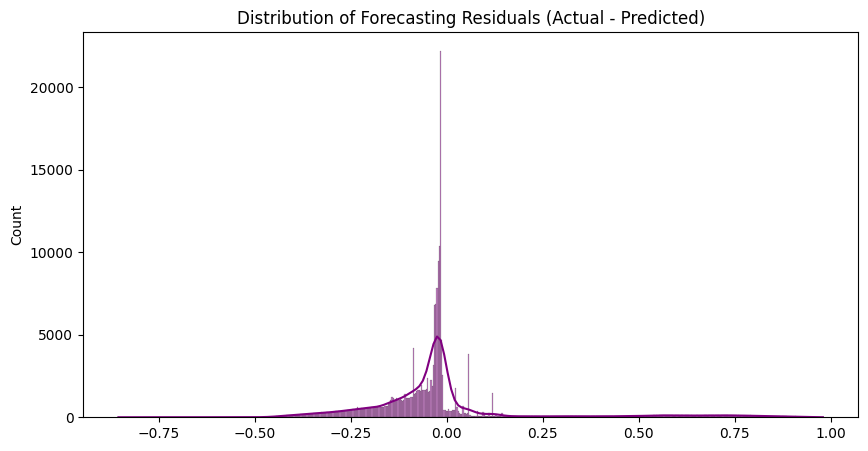

In [35]:
# Calculate the forecasting residuals by subtracting
# the model predictions from the actual sensor values.
residuals = y_test_b - y_test_pred_b.flatten()

# Initialize a plot to visualize the distribution of residuals
# using a histogram and kernel density estimate (KDE).
plt.figure(figsize=(10, 5))

# Use the seaborn library to render the residual distribution,
# which helps identify potential bias or systematic errors in the forecast.
sns.histplot(residuals, kde=True, color="purple")

# Set the title for the visualization to clearly define the content of the plot.
plt.title("Distribution of Forecasting Residuals (Actual - Predicted)")

# Display the final plot for analysis.
plt.show()

## Model B Summary

Model B implements a supervised LSTM regression model that forecasts
compressor pressure (TP2) 10 minutes ahead using 30 minutes of
multivariate sensor history.

**Key design decisions:**
- Shrinking 64→32 LSTM architecture selected after empirical comparison
  with 64→128, which produced overfitting
- Chronological train/test split preserving temporal integrity
- Continuous sensors only — binary signals excluded to prevent
  state-machine memorization
- MSE loss to penalize large pressure deviations

**Results:** MAE 0.1369, RMSE 0.2383, R² 0.4368 on scaled test data.
Performance reflects TP2's inherently discontinuous dynamics. The model
serves as a complementary early warning signal to Model A rather than
a standalone fault detector.

**Outputs exported for Tableau:**
- `model_b_forecast_results.csv` — Actual vs. predicted TP2 with
  residuals and rolling error for dashboard visualization.